# Learning Models with Simulations
Lecture 3
Vincent Wilmet


## EX. 1

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [259]:
Y = [125, 18, 20, 34]

In [260]:
def loglikelihood(x):
  return Y[0]*np.log(2+x) + (Y[1] + Y[2])*np.log(1-x) + Y[3]*np.log(x)

def negloglikelihood(x):
  return -loglikelihood(x)

In [261]:
res = minimize_scalar(negloglikelihood, bounds=(0, 1), method="bounded")

In [262]:
res

     fun: -67.38410209471839
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.6268214005392267

In [263]:
neglogC = res.fun

In [264]:
S = []
N = 10000

while len(S) < N:
  U = np.random.uniform(low=0.0, high=1.0, size=None)
  logU = np.log(U)
  theta = np.random.uniform(low=0.0, high=1.0, size=None)
  logLikelyTheta = loglikelihood(theta)

  if logU < (logLikelyTheta + neglogC):
    S.append(theta)

In [265]:
S[9995:]

[0.6556313363814987,
 0.612909769770907,
 0.6239416560340727,
 0.5828681040399073,
 0.690682902112105]

(array([  14.,   68.,  276., 1047., 2114., 2818., 2260., 1105.,  278.,
          20.]),
 array([0.41937695, 0.45625549, 0.49313403, 0.53001258, 0.56689112,
        0.60376966, 0.6406482 , 0.67752675, 0.71440529, 0.75128383,
        0.78816237]),
 <a list of 10 Patch objects>)

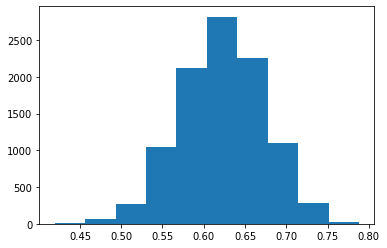

In [266]:
plt.hist( S)

In [267]:
mu = np.mean(S)
sigma = np.std(S)
print(mu, sigma)

0.6221616569620941 0.05086806095323194


## EX. 2:

In [268]:
from scipy.stats import t, norm
import matplotlib.pyplot as plt
N = 10000

In [269]:
def f(x):
  return np.abs(x)

def unnormalized_density(x):
  return -2*np.log(1 + x**2 /3)

def log_importance_weight(x, df):
  return unnormalized_density(x) - t.logpdf(x, df)

def log_importance_weight_norm(x):
  return unnormalized_density(x) - norm.logpdf(x, 0, 1)

In [270]:
# Proposal distribution 1: q(x) = p(x) is a t-distribution with 3 degrees of freedom
df_1 = 3
r_1 = t.rvs(df_1, size=N)
w_1 = log_importance_weight(r_1, df_1)

In [271]:
# Proposal distribution 2: q(x) is a t-distribution with 1 degrees of freedom
df_2 = 1
r_2 = t.rvs(df_2, size=N)
w_2 = log_importance_weight(r_2, df_2)

In [272]:
# Proposal distribution 3: q(x) is a standard Normal N(0, 1)
r_3 = norm.rvs(size=N)
w_3 = log_importance_weight_norm(r_3)

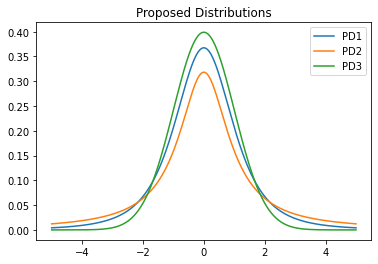

In [273]:
grid = np.linspace(-5,5, N)
plt.plot(grid, t.pdf(grid, df_1), label='PD1')
plt.plot(grid, t.pdf(grid, df_2), label='PD2')
plt.plot(grid, norm.pdf(grid), label='PD3')
plt.title("Proposed Distributions")
plt.legend()
plt.show()

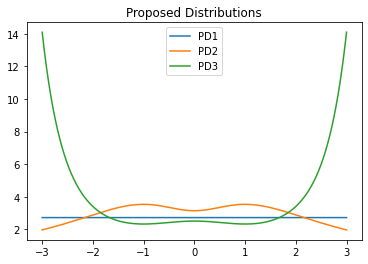

In [274]:
grid = np.linspace(-3,3, N)
plt.plot(grid, np.exp(log_importance_weight(grid, df_1)), label='PD1')
plt.plot(grid, np.exp(log_importance_weight(grid, df_2)), label='PD2')
plt.plot(grid, np.exp(log_importance_weight_norm(grid)), label='PD3')
plt.title("Proposed Distributions")
plt.legend()
plt.show()

In [295]:
def An(X, df):
  if df==None: return np.mean(np.exp(np.log(f(X)) + log_importance_weight_norm(X)))
  return np.mean(np.exp(np.log(f(X)) + log_importance_weight(X, df)))

def Zn(X, df=None):
  if df==None: return np.mean(np.exp(log_importance_weight_norm(X)))
  return np.mean(np.exp(log_importance_weight(X, df)))

def In(X, df=None):
  return An(X, df)/Zn(X, df)

In [296]:
NIS_1 = In(r_1, df_1)
NIS_2 = In(r_2, df_2)
NIS_3 = In(r_3)

In [297]:
print("NIS_1: ", NIS_1, "\n"
      "NIS_2: ", NIS_2, "\n"
      "NIS_3: ", NIS_3)

NIS_1:  1.0940432406493654 
NIS_2:  1.1003850881859267 
NIS_3:  0.9489850396173222


In [298]:
Zn_1 = Zn(r_1, df_1)
Zn_2 = Zn(r_2, df_2)
Zn_3 = Zn(r_3)

In [299]:
print("Zn_1: ", np.log(Zn_1), "\n"
      "Zn_2: ", np.log(Zn_2), "\n"
      "Zn_3: ", np.log(Zn_3))

Zn_1:  1.0008888496235098 
Zn_2:  0.9989127666691102 
Zn_3:  0.9709880430890441


In [305]:
def ESS(W):
  return 1/sum(np.square(W))

def logsumexp(logW):
    c = logW.max()
    return c + np.log(np.sum(np.exp(logW - c)))

def normalized_weights(logW, logsumtrick=False):
  if logsumtrick: w = np.exp(logW - logsumexp(logW))
  else: w = np.exp(logW)
  s = sum(w)
  return w/s

In [306]:
print("ESS1: ", ESS(normalized_weights(w_1)), "\n"
      "ESS2: ", ESS(normalized_weights(w_2)), "\n"
      "ESS3: ", ESS(normalized_weights(w_3)))

ESS1:  10000.000000004398 
ESS2:  8652.854737969765 
ESS3:  6397.392604192071


Here we see that ESS of Proposed Distribution 2 (PD2) loses some efficiency, and PD3 is 1/3 as efficient.

PD3 also has the fault that its weights are unbounded at the ends, which can cause a bias. 

PD2 has a bounded weight distribution, which makes it the most appealing PD for `q(x)`. 

In [301]:
print("ESS1: ", ESS(normalized_weights(w_1, logsumtrick=True)), "\n"
      "ESS2: ", ESS(normalized_weights(w_2, logsumtrick=True)), "\n"
      "ESS3: ", ESS(normalized_weights(w_3, logsumtrick=True)))

ESS1:  9999.999999995747 
ESS2:  8652.85473796987 
ESS3:  6397.392604192083


We can see that with the logsum trick the ESS values slightly. However, this allows for a safe computation of `np.exp(logW)` that wont overflow beyond the computer system's `INT_MAX`